In [1]:
filepath = "data_files/financial_basis/all_stocks_5yr.csv"

In [2]:
import pandas as pd


df = pd.read_csv(filepath, parse_dates=['date'])
df.set_index('date', inplace=True)

df.head()

,open,high,low,close,volume,Name
date,,,,,,
2013-02-08,15.07,15.12,14.63,14.75,8407500,AAL
2013-02-11,14.89,15.01,14.26,14.46,8882000,AAL
2013-02-12,14.45,14.51,14.10,14.27,8126000,AAL
2013-02-13,14.30,14.94,14.25,14.66,10259500,AAL
2013-02-14,14.94,14.96,13.16,13.99,31879900,AAL


In [3]:
import numpy as np
from plotting import plot_ts

def view_random_stock(stock_name = None):
    if not stock_name:
        stock_name = np.random.choice(df['Name'])
    stock = df[df['Name'] == stock_name]
    x = stock.index
    y = stock['close']
    plot_ts(x,y, title = f"Close Price of {stock_name}")

In [4]:
view_random_stock()

In [5]:
view_random_stock()

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 619040 entries, 2013-02-08 to 2018-02-07
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   open    619029 non-null  float64
 1   high    619032 non-null  float64
 2   low     619032 non-null  float64
 3   close   619040 non-null  float64
 4   volume  619040 non-null  int64  
 5   Name    619040 non-null  object 
dtypes: float64(4), int64(1), object(1)
memory usage: 33.1+ MB


In [7]:
from functools import reduce

def combine_stocks(df):
    """Why not pivot table for this problem?"""
    
    # find min date and max date
    start_date, end_date = df.index.min(), df.index.max()

    # continuous date range starting from start_date ending at end_date
    date_index = pd.date_range(start_date, end_date)

    # make a dataframe contain only date indices
    close_prices = pd.DataFrame(index = date_index)

    # extract all symbol names
    symbols = df['Name'].unique()

    # function that retrieve 1 stock close price
    get_stock_df = lambda stock_name: df[df['Name'] == stock_name][['close']]\
                                        .rename(columns={'close': stock_name})

    # generator for all stocks
    stock_df_generator = (get_stock_df(symbol) for symbol in symbols)

    # merge all stocks into 1 dataframe, each stock is a column
    all_stocks = reduce(lambda left, right: left.join(right), (close_prices, *stock_df_generator))
    return all_stocks

In [8]:
all_stocks = combine_stocks(df)

In [10]:
all_stocks.head()

,AAL,AAPL,AAP,ABBV,ABC,ABT,ACN,ADBE,ADI,ADM,...,XLNX,XL,XOM,XRAY,XRX,XYL,YUM,ZBH,ZION,ZTS
2013-02-08,14.75,67.8542,78.90,36.25,46.89,34.41,73.31,39.12,45.70,30.22,...,37.51,28.24,88.61,42.87,31.84,27.09,65.30,75.85,24.14,33.05
2013-02-09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2013-02-11,14.46,68.5614,78.39,35.85,46.76,34.26,73.07,38.64,46.08,30.28,...,37.46,28.31,88.28,42.84,31.96,27.46,64.55,75.65,24.21,33.26
2013-02-12,14.27,66.8428,78.60,35.42,46.96,34.30,73.37,38.89,46.27,30.81,...,37.58,28.41,88.46,42.87,31.84,27.95,64.75,75.44,24.49,33.74


<AxesSubplot:title={'center':'Missing Percent'}>

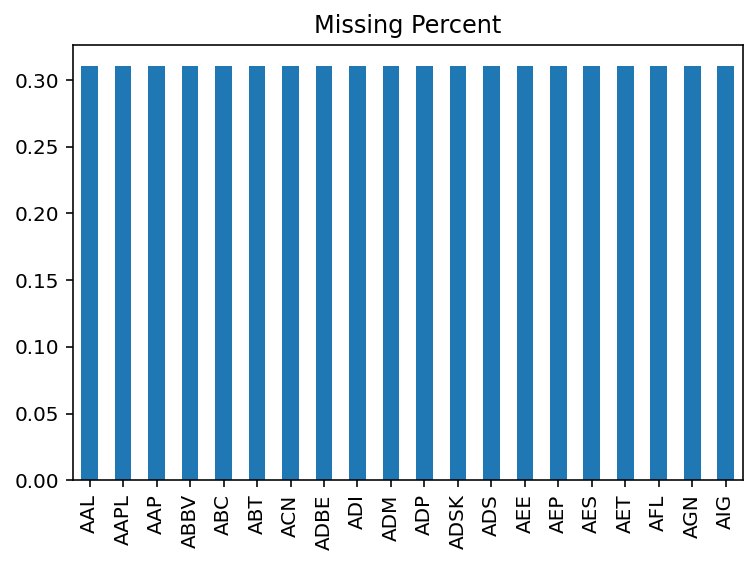

In [11]:
%config InlineBackend.figure_format = 'retina'
all_stocks.iloc[:,:20].isnull().mean().plot(kind='bar', title = 'Missing Percent')

In [12]:
all_stocks.dropna(axis = 0, how = 'all',inplace = True)

<AxesSubplot:title={'center':'Missing Percent'}>

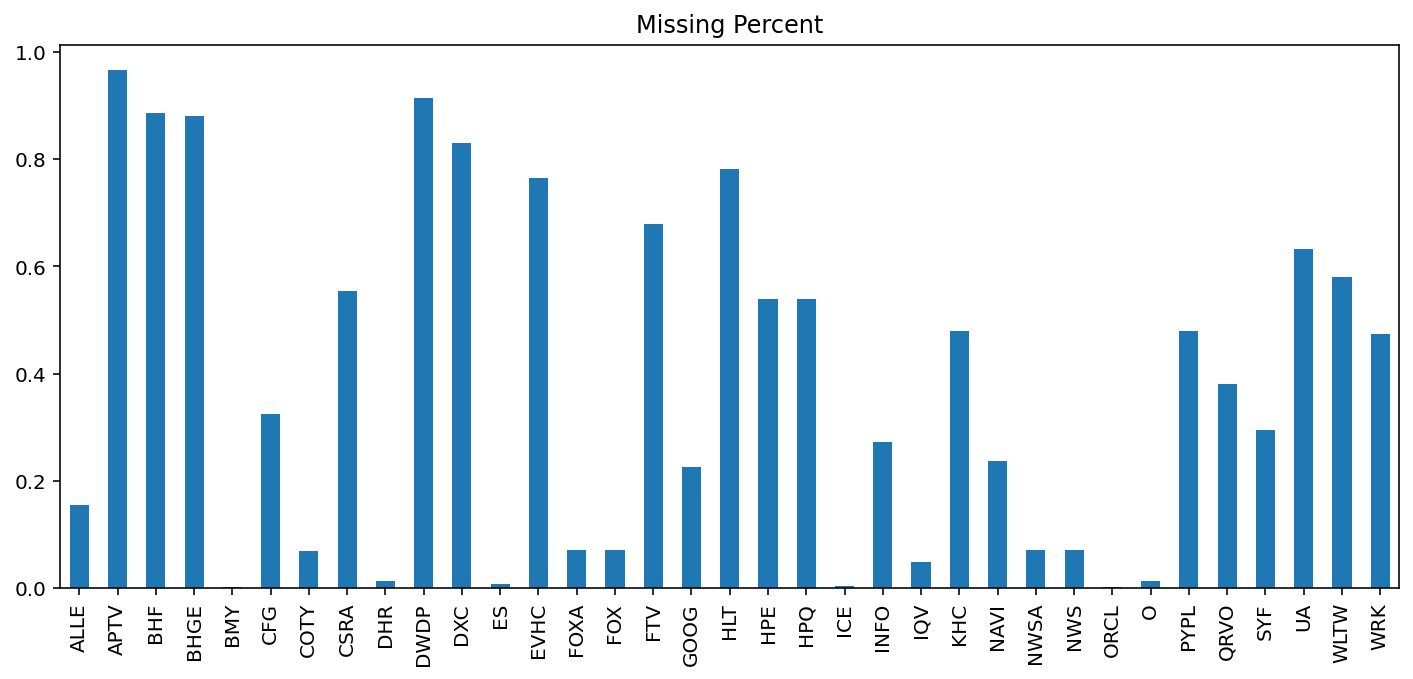

In [13]:
nulls = all_stocks.isnull().mean()
all_stocks[nulls[nulls > 0].index].isnull().mean().plot(kind='bar', title = 'Missing Percent', figsize = (12,5))

### Checking Missing Values

In [14]:
view_random_stock("ALLE")

In [15]:
view_random_stock("APTV")

In [16]:
view_random_stock("CFG")

In [17]:
from ts_gen import SimpleRandomWalk
import plotly.graph_objects as go

x_raw, y_raw = SimpleRandomWalk(n = 1000).generate()
x = x_raw.copy()
y = y_raw.copy()
y[:100] = None
y[400:500] = None
y[-100:] = None

scatter1 = go.Scatter(x = x_raw, y = y_raw, name = "Raw Data",
            line = {'color':"royalblue","dash":'dash'})

scatter2 = go.Scatter(x = x,y = y, name = "Missing Data",
            line = {"color":"firebrick"}, opacity = 0.5)

fig = go.Figure([scatter1, scatter2])

fig.update_layout({'title':"Time Series With Missing Data"})
fig.update_xaxes(title_text = "Timestep")
fig.update_yaxes(title_text = "Value")
fig

### Fill data with interpolation

In [52]:
from scipy import interpolate

# generate time series
x_raw, y_raw = SimpleRandomWalk(n = 1000).generate()
x = x_raw.copy()
y = y_raw.copy()
y[400:500] = None

# linear fit time series
x_fit = np.r_[x[:400], x[500:]]
y_fit = np.r_[y[:400], y[500:]]

f = interpolate.interp1d(x_fit, y_fit, kind = 'linear')
x_new = x
y_new = f(x_new)

# ensure non-null for all y values
assert np.isnan(y_new).sum() == 0

# plot time series
scatter1 = go.Scatter(x = x, y = y, name = "Data with missing",
            line = {'color':"royalblue","dash":'dash'})

scatter2 = go.Scatter(x = x_new,y = y_new, name = "Filled series",
            line = {"color":"firebrick"},marker = {"size":5}, opacity = 0.5, mode = "lines+markers")

fig = go.Figure([scatter1, scatter2])

fig.update_layout({'title':"Fill missing values (Wrong: mix future data into past)"})
fig.update_xaxes(title_text = "Timestep")
fig.update_yaxes(title_text = "Value")

### Forward filling

In [53]:
x_raw, y_raw = SimpleRandomWalk(n = 1000).generate()
x = x_raw.copy()
y = y_raw.copy()
y[:100] = None
y[400:500] = None
y[-100:] = None

df = pd.DataFrame(np.c_[x,y], columns = ['x','y'])
df['x'] = df['x'].astype(int)
df['y'] = df['y'].ffill()
x_new, y_new = df.x, df.y

# plot time series
scatter1 = go.Scatter(x = x, y = y, name = "Data with missing",
            line = {'color':"royalblue","dash":'dash'})

scatter2 = go.Scatter(x = x_new,y = y_new, name = "Filled series",
            line = {"color":"firebrick"},marker = {"size":5}, opacity = 0.5, mode = "lines+markers")

fig = go.Figure([scatter1, scatter2])

fig.update_layout({'title':"Fill missing values"})
fig.update_xaxes(title_text = "Timestep")
fig.update_yaxes(title_text = "Value")

### Forward and backward fill

In [54]:
x_raw, y_raw = SimpleRandomWalk(n = 1000).generate()
x = x_raw.copy()
y = y_raw.copy()
y[:100] = None
y[400:500] = None
y[-100:] = None

df = pd.DataFrame(np.c_[x,y], columns = ['x','y'])
df['x'] = df['x'].astype(int)
df['y'] = df['y'].ffill().bfill()
x_new, y_new = df.x, df.y

# plot time series
scatter1 = go.Scatter(x = x, y = y, name = "Data with missing",
            line = {'color':"royalblue","dash":'dash'})

scatter2 = go.Scatter(x = x_new,y = y_new, name = "Filled series",
            line = {"color":"firebrick"},marker = {"size":5}, opacity = 0.5, mode = "lines+markers")

fig = go.Figure([scatter1, scatter2])

fig.update_layout({'title':"Fill missing values"})
fig.update_xaxes(title_text = "Timestep")
fig.update_yaxes(title_text = "Value")

In [55]:
df = all_stocks.ffill().bfill()
no_missing = all(df.isnull().sum().values == 0)
print("all na fillled? {}".format(no_missing))

all na fillled? True


In [56]:
import random

symbols = df.columns.tolist()
stocks = random.choices(symbols, k = 10)

fig = go.Figure(
    [go.Scatter(x = df.index,y = df[stock], name = stock) 
    for stock in stocks]
)

fig.update_layout({'title':"Randomly selected stock prices"})
fig.update_xaxes(title_text = "Timestep")
fig.update_yaxes(title_text = "Value")

In [57]:
stocks_df = df[stocks]
change_df = stocks_df / stocks_df.iloc[0]

fig = go.Figure(
    [go.Scatter(x = change_df.index,y = change_df[stock], name = stock) 
    for stock in stocks]
)

fig.update_layout({'title':"Randomly selected stock changes"})
fig.update_xaxes(title_text = "Timestep")
fig.update_yaxes(title_text = "Value")

In [51]:
stocks_df = df[stocks]
change_df = stocks_df.pct_change()

fig = go.Figure(
    [go.Scatter(x = change_df.index,y = change_df[stock], name = stock) 
    for stock in stocks]
)

fig.update_layout({'title':"Randomly selected stock percent change"})
fig.update_xaxes(title_text = "Timestep")
fig.update_yaxes(title_text = "Value")